# Association

Modelling the explicit labelling of observations from different population components and comparison with standard mixture modelling and clustering techniques.

Model definition and simulation is done in `pyStan` with code in the `stan/` directory.

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import pystan

## A simple mixture model

Consider observations drawn from a mixture of 2 gaussian distributions with different means and the same standard deviation. Each population has an associated weight, $w$, the set of which forms a 2-simplex. The model can be parameterised with a latent categorical variable or *label*, $\lambda$:

<div><center>
    $\lambda \sim Categorical(w)$   
    <center></div>

The observation $y_n$ is distributed according to which mixture componenet it is generated from.

<div><center>
    $y_n \sim Normal(\mu_n, \sigma^2)$   
    <center></div>
    
In order to treat this model in Stan, we marginalise over the discrete parameter:

<div><center>
    $p(y \ | \ w, \mu, \sigma) = \sum_{k = 1}^2 Normal( y \ | \ \mu_k, \sigma^2) $  
    <center></div>
    
  

In [28]:
# compile the stan simulation
simu_file = 'stan/simple_mixture_sim.stan'
simulation = pystan.StanModel(file = simu_file)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2158d8774e195f442b1410958bbc38a6 NOW.


ValueError: Failed to parse Stan model 'anon_model_7ca16bf5ef1bd52ba81715d1425c2d55'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

No matches for: 

  log_mix(vector, real, real)

Available argument signatures for log_mix:

  log_mix(real, real, real)

  error in 'unknown file name' at line 22, column 95
  -------------------------------------------------
    20: model {
    21:   for (i in 1:N_obs) {
    22:     target += log_mix( w, normal_lpdf(y[i] | mu[1], sigma), normal_lpdf(y[i] | mu[2], sigma) );
                                                                                                      ^
    23:   }
  -------------------------------------------------



/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


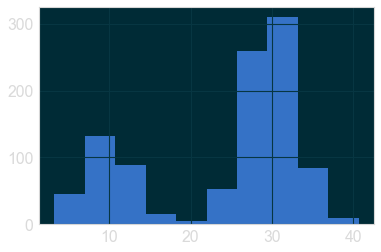

In [27]:
# Use stan to simulate draws from this mixutre model
simu_parameters = {'mu' : [10, 30],
                   'sigma' : 3, 
                   'w' : [0.3, 0.7], 
                   'N_obs' : 1000}

sim = simulation.sampling(data = simu_parameters, algorithm = "Fixed_param", 
                     iter = 1, chains = 1, seed = 19920715)

# plot the simulation
y_simu = sim.extract(['y'])['y'][0]
plt.hist(y_simu);

# dump the data to a file

In [ ]:
# compile the stan model
model_file = 'stan/simple_mixture.stan'
model = pystan.StanModel(file = model_file)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bec746fa45b876654629650019ef846c NOW.


In [30]:
# fit the stan model
data = {'N_obs' : len(y_simu),
        'y' : y_simu}

fit = model.sampling(data = data, iter = 1000, chains = 4, seed = 19920715)
print(fit)

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
